# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.475857044302096 -2.467672892743712
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            #break
            print('Won!')
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints4/model2.ckpt')

Episode:0 meanR:8.0000 gloss:-0.0367 dloss:0.6619 dlossR:0.6619 dlossQ:0.6923
Episode:1 meanR:9.0000 gloss:-0.0500 dloss:0.6556 dlossR:0.6556 dlossQ:0.6920
Episode:2 meanR:9.3333 gloss:-0.0931 dloss:0.6285 dlossR:0.6285 dlossQ:0.6896
Episode:3 meanR:9.5000 gloss:-0.1461 dloss:0.5836 dlossR:0.5836 dlossQ:0.6826
Episode:4 meanR:9.6000 gloss:-0.1845 dloss:0.5634 dlossR:0.5634 dlossQ:0.6782
Episode:5 meanR:10.6667 gloss:-0.1701 dloss:0.5826 dlossR:0.5826 dlossQ:0.6799
Episode:6 meanR:21.2857 gloss:-0.1018 dloss:0.6472 dlossR:0.6472 dlossQ:0.6904
Episode:7 meanR:26.1250 gloss:-0.1194 dloss:0.6308 dlossR:0.6308 dlossQ:0.6893
Episode:8 meanR:37.4444 gloss:-0.1201 dloss:0.6541 dlossR:0.6541 dlossQ:0.6893
Episode:9 meanR:39.7000 gloss:-0.1444 dloss:0.6183 dlossR:0.6183 dlossQ:0.6875
Episode:10 meanR:43.2727 gloss:-0.1517 dloss:0.6232 dlossR:0.6232 dlossQ:0.6870
Episode:11 meanR:44.9167 gloss:-0.1701 dloss:0.6075 dlossR:0.6075 dlossQ:0.6853
Episode:12 meanR:44.1538 gloss:-0.2052 dloss:0.5756 dlo

Episode:107 meanR:38.9100 gloss:-1.7049 dloss:0.1605 dlossR:0.1605 dlossQ:0.2703
Episode:108 meanR:37.7500 gloss:-1.8227 dloss:0.1335 dlossR:0.1335 dlossQ:0.2408
Episode:109 meanR:37.2800 gloss:-1.9217 dloss:0.1349 dlossR:0.1349 dlossQ:0.2210
Episode:110 meanR:36.5900 gloss:-2.0267 dloss:0.1144 dlossR:0.1144 dlossQ:0.1988
Episode:111 meanR:36.0800 gloss:-2.1126 dloss:0.1259 dlossR:0.1259 dlossQ:0.1877
Episode:112 meanR:35.8400 gloss:-2.1178 dloss:0.1187 dlossR:0.1187 dlossQ:0.1864
Episode:113 meanR:35.3800 gloss:-2.0345 dloss:0.1183 dlossR:0.1183 dlossQ:0.1989
Episode:114 meanR:34.8600 gloss:-1.9974 dloss:0.1308 dlossR:0.1308 dlossQ:0.2074
Episode:115 meanR:34.7600 gloss:-1.9137 dloss:0.1721 dlossR:0.1721 dlossQ:0.2237
Episode:116 meanR:34.5700 gloss:-1.9155 dloss:0.1722 dlossR:0.1722 dlossQ:0.2239
Episode:117 meanR:34.4400 gloss:-1.9387 dloss:0.1991 dlossR:0.1991 dlossQ:0.2173
Episode:118 meanR:34.7900 gloss:-1.8579 dloss:0.3731 dlossR:0.3731 dlossQ:0.2356
Episode:119 meanR:34.7200 gl

Episode:211 meanR:29.3600 gloss:-1.7192 dloss:0.1663 dlossR:0.1663 dlossQ:0.2731
Episode:212 meanR:29.4000 gloss:-1.8130 dloss:0.1517 dlossR:0.1517 dlossQ:0.2504
Episode:213 meanR:29.4200 gloss:-1.9117 dloss:0.1375 dlossR:0.1375 dlossQ:0.2291
Episode:214 meanR:29.4300 gloss:-1.9843 dloss:0.1400 dlossR:0.1400 dlossQ:0.2140
Episode:215 meanR:29.3500 gloss:-2.0632 dloss:0.1279 dlossR:0.1279 dlossQ:0.2005
Episode:216 meanR:29.2500 gloss:-2.3390 dloss:0.1130 dlossR:0.1130 dlossQ:0.1610
Episode:217 meanR:29.1400 gloss:-1.9393 dloss:0.1420 dlossR:0.1420 dlossQ:0.2248
Episode:218 meanR:29.0000 gloss:-1.8078 dloss:0.2984 dlossR:0.2984 dlossQ:0.2540
Episode:219 meanR:29.4400 gloss:-1.6856 dloss:0.3824 dlossR:0.3824 dlossQ:0.2821
Episode:220 meanR:29.3700 gloss:-1.8736 dloss:0.1590 dlossR:0.1590 dlossQ:0.2368
Episode:221 meanR:29.2900 gloss:-1.9570 dloss:0.1295 dlossR:0.1295 dlossQ:0.2192
Episode:222 meanR:29.1600 gloss:-1.9894 dloss:0.1336 dlossR:0.1336 dlossQ:0.2111
Episode:223 meanR:29.0800 gl

Episode:315 meanR:44.8400 gloss:-1.4357 dloss:0.3552 dlossR:0.3552 dlossQ:0.3503
Episode:316 meanR:45.1300 gloss:-1.4161 dloss:0.2813 dlossR:0.2813 dlossQ:0.3562
Episode:317 meanR:45.5900 gloss:-1.5031 dloss:0.3689 dlossR:0.3689 dlossQ:0.3296
Episode:318 meanR:45.4500 gloss:-1.4801 dloss:0.2358 dlossR:0.2358 dlossQ:0.3372
Episode:319 meanR:45.2300 gloss:-1.5469 dloss:0.2763 dlossR:0.2763 dlossQ:0.3171
Episode:320 meanR:45.3800 gloss:-1.5128 dloss:0.2466 dlossR:0.2466 dlossQ:0.3268
Episode:321 meanR:45.4500 gloss:-1.5719 dloss:0.1850 dlossR:0.1850 dlossQ:0.3106
Episode:322 meanR:45.6200 gloss:-1.5896 dloss:0.2340 dlossR:0.2340 dlossQ:0.3052
Episode:323 meanR:45.7600 gloss:-1.6091 dloss:0.2240 dlossR:0.2240 dlossQ:0.3002
Episode:324 meanR:45.8700 gloss:-1.6118 dloss:0.2054 dlossR:0.2054 dlossQ:0.2999
Episode:325 meanR:45.9300 gloss:-1.6129 dloss:0.1780 dlossR:0.1780 dlossQ:0.2998
Episode:326 meanR:45.9600 gloss:-1.7396 dloss:0.1554 dlossR:0.1554 dlossQ:0.2671
Episode:327 meanR:46.0300 gl

Episode:421 meanR:28.9800 gloss:-2.1580 dloss:0.1163 dlossR:0.1163 dlossQ:0.1805
Episode:422 meanR:28.8000 gloss:-2.0822 dloss:0.1247 dlossR:0.1247 dlossQ:0.1948
Episode:423 meanR:28.6300 gloss:-2.1203 dloss:0.1172 dlossR:0.1172 dlossQ:0.1875
Episode:424 meanR:28.5300 gloss:-2.1286 dloss:0.1347 dlossR:0.1347 dlossQ:0.1861
Episode:425 meanR:28.6400 gloss:-2.4831 dloss:0.2518 dlossR:0.2518 dlossQ:0.1636
Episode:426 meanR:28.5900 gloss:-2.8266 dloss:0.1124 dlossR:0.1124 dlossQ:0.1129
Episode:427 meanR:28.5300 gloss:-2.3723 dloss:0.1137 dlossR:0.1137 dlossQ:0.1493
Episode:428 meanR:28.4600 gloss:-2.4073 dloss:0.1077 dlossR:0.1077 dlossQ:0.1458
Episode:429 meanR:28.4800 gloss:-2.1993 dloss:0.1290 dlossR:0.1290 dlossQ:0.1775
Episode:430 meanR:28.4900 gloss:-2.3526 dloss:0.1315 dlossR:0.1315 dlossQ:0.1470
Episode:431 meanR:28.6500 gloss:-2.0739 dloss:0.2129 dlossR:0.2129 dlossQ:0.1967
Episode:432 meanR:28.8600 gloss:-1.9093 dloss:0.2563 dlossR:0.2563 dlossQ:0.2307
Episode:433 meanR:28.9500 gl

Episode:525 meanR:43.9200 gloss:-1.3185 dloss:0.6276 dlossR:0.6276 dlossQ:0.3868
Episode:526 meanR:44.4800 gloss:-1.3128 dloss:0.3918 dlossR:0.3918 dlossQ:0.3888
Episode:527 meanR:44.8300 gloss:-1.3349 dloss:0.3143 dlossR:0.3143 dlossQ:0.3818
Episode:528 meanR:45.0100 gloss:-1.3931 dloss:0.2396 dlossR:0.2396 dlossQ:0.3647
Episode:529 meanR:45.2300 gloss:-1.3239 dloss:0.2731 dlossR:0.2731 dlossQ:0.3862
Episode:530 meanR:45.4200 gloss:-1.3522 dloss:0.2630 dlossR:0.2630 dlossQ:0.3781
Episode:531 meanR:45.4100 gloss:-1.3803 dloss:0.2333 dlossR:0.2333 dlossQ:0.3708
Episode:532 meanR:45.3000 gloss:-1.3825 dloss:0.2253 dlossR:0.2253 dlossQ:0.3700
Episode:533 meanR:45.3800 gloss:-1.3641 dloss:0.2553 dlossR:0.2553 dlossQ:0.3777
Episode:534 meanR:45.2700 gloss:-1.4631 dloss:0.2145 dlossR:0.2145 dlossQ:0.3485
Episode:535 meanR:45.0000 gloss:-1.5169 dloss:0.1928 dlossR:0.1928 dlossQ:0.3328
Episode:536 meanR:44.3500 gloss:-1.6100 dloss:0.1801 dlossR:0.1801 dlossQ:0.3061
Episode:537 meanR:44.3900 gl

Episode:633 meanR:55.3900 gloss:-0.9903 dloss:1.6480 dlossR:1.6480 dlossQ:0.4926
Episode:634 meanR:60.1600 gloss:-1.2192 dloss:1.9200 dlossR:1.9200 dlossQ:0.4185
Episode:635 meanR:63.0300 gloss:-0.8421 dloss:1.0202 dlossR:1.0202 dlossQ:0.5349
Episode:636 meanR:64.0000 gloss:-0.8525 dloss:0.5625 dlossR:0.5625 dlossQ:0.5293
Episode:637 meanR:64.4800 gloss:-0.9665 dloss:0.4416 dlossR:0.4416 dlossQ:0.4983
Episode:638 meanR:64.6400 gloss:-1.1806 dloss:0.3141 dlossR:0.3141 dlossQ:0.4328
Episode:639 meanR:65.1400 gloss:-0.9377 dloss:0.4403 dlossR:0.4403 dlossQ:0.5068
Episode:640 meanR:65.3200 gloss:-1.2532 dloss:0.2931 dlossR:0.2931 dlossQ:0.4095
Episode:641 meanR:65.4500 gloss:-1.1477 dloss:0.2820 dlossR:0.2820 dlossQ:0.4432
Episode:642 meanR:65.5400 gloss:-1.2786 dloss:0.2528 dlossR:0.2528 dlossQ:0.4027
Episode:643 meanR:65.6800 gloss:-1.3182 dloss:0.2703 dlossR:0.2703 dlossQ:0.3902
Episode:644 meanR:65.8100 gloss:-1.1847 dloss:0.2748 dlossR:0.2748 dlossQ:0.4317
Episode:645 meanR:66.4000 gl

Episode:735 meanR:54.2700 gloss:-1.5670 dloss:0.2914 dlossR:0.2914 dlossQ:0.3187
Episode:736 meanR:53.5700 gloss:-1.7543 dloss:0.3067 dlossR:0.3067 dlossQ:0.2688
Episode:737 meanR:53.1200 gloss:-1.7157 dloss:0.2321 dlossR:0.2321 dlossQ:0.2789
Episode:738 meanR:53.0000 gloss:-1.6899 dloss:0.2336 dlossR:0.2336 dlossQ:0.2862
Episode:739 meanR:52.5500 gloss:-1.6475 dloss:0.2262 dlossR:0.2262 dlossQ:0.2978
Episode:740 meanR:52.4100 gloss:-1.7947 dloss:0.2012 dlossR:0.2012 dlossQ:0.2609
Episode:741 meanR:52.3800 gloss:-1.6617 dloss:0.2273 dlossR:0.2273 dlossQ:0.2950
Episode:742 meanR:52.3100 gloss:-1.6772 dloss:0.1890 dlossR:0.1890 dlossQ:0.2911
Episode:743 meanR:52.2200 gloss:-1.6836 dloss:0.2081 dlossR:0.2081 dlossQ:0.2901
Episode:744 meanR:52.1600 gloss:-1.6755 dloss:0.2078 dlossR:0.2078 dlossQ:0.2920
Episode:745 meanR:51.7000 gloss:-2.2486 dloss:0.2497 dlossR:0.2497 dlossQ:0.1821
Episode:746 meanR:51.4700 gloss:-1.8062 dloss:0.2442 dlossR:0.2442 dlossQ:0.2601
Episode:747 meanR:51.4500 gl

Episode:837 meanR:48.3400 gloss:-0.9660 dloss:0.4969 dlossR:0.4969 dlossQ:0.4915
Episode:838 meanR:49.5900 gloss:-0.6104 dloss:0.6622 dlossR:0.6622 dlossQ:0.5840
Episode:839 meanR:51.4800 gloss:-0.6070 dloss:0.7678 dlossR:0.7678 dlossQ:0.5870
Episode:840 meanR:52.8500 gloss:-0.9372 dloss:0.6805 dlossR:0.6805 dlossQ:0.5085
Episode:841 meanR:55.2500 gloss:-1.0034 dloss:1.0011 dlossR:1.0011 dlossQ:0.4885
Episode:842 meanR:55.4000 gloss:-1.3960 dloss:0.2728 dlossR:0.2728 dlossQ:0.3683
Episode:843 meanR:55.9000 gloss:-1.2983 dloss:0.4283 dlossR:0.4283 dlossQ:0.3985
Episode:844 meanR:56.8300 gloss:-1.0496 dloss:0.5655 dlossR:0.5655 dlossQ:0.4747
Episode:845 meanR:57.9800 gloss:-1.0521 dloss:0.6482 dlossR:0.6482 dlossQ:0.4739
Episode:846 meanR:59.5000 gloss:-1.1196 dloss:0.7896 dlossR:0.7896 dlossQ:0.4513
Episode:847 meanR:60.0700 gloss:-0.9649 dloss:0.4920 dlossR:0.4920 dlossQ:0.4999
Episode:848 meanR:60.2500 gloss:-1.4262 dloss:0.2685 dlossR:0.2685 dlossQ:0.3642
Episode:849 meanR:60.4500 gl

Episode:939 meanR:64.6300 gloss:-1.5392 dloss:0.2756 dlossR:0.2756 dlossQ:0.3247
Episode:940 meanR:63.3900 gloss:-1.8994 dloss:0.2700 dlossR:0.2700 dlossQ:0.2361
Episode:941 meanR:61.7100 gloss:-0.7169 dloss:0.5651 dlossR:0.5651 dlossQ:0.5551
Episode:942 meanR:61.4700 gloss:-2.0826 dloss:0.1320 dlossR:0.1320 dlossQ:0.2084
Episode:943 meanR:61.5400 gloss:-1.5313 dloss:0.4677 dlossR:0.4677 dlossQ:0.3287
Episode:944 meanR:61.9600 gloss:-1.2693 dloss:0.7440 dlossR:0.7440 dlossQ:0.4064
Episode:945 meanR:60.6000 gloss:-2.1227 dloss:0.1256 dlossR:0.1256 dlossQ:0.2042
Episode:946 meanR:62.7200 gloss:-0.7708 dloss:1.1906 dlossR:1.1906 dlossQ:0.5538
Episode:947 meanR:63.8400 gloss:-0.5971 dloss:0.7445 dlossR:0.7445 dlossQ:0.5898
Episode:948 meanR:64.9400 gloss:-0.5670 dloss:0.6447 dlossR:0.6447 dlossQ:0.5925
Episode:949 meanR:65.6400 gloss:-0.8719 dloss:0.5606 dlossR:0.5606 dlossQ:0.5093
Episode:950 meanR:65.1600 gloss:-1.7532 dloss:0.1779 dlossR:0.1779 dlossQ:0.2683
Episode:951 meanR:64.4200 gl

Episode:1045 meanR:47.8900 gloss:-1.7978 dloss:0.2162 dlossR:0.2162 dlossQ:0.2681
Episode:1046 meanR:44.9500 gloss:-1.3718 dloss:0.5483 dlossR:0.5483 dlossQ:0.3749
Episode:1047 meanR:45.3300 gloss:-1.1557 dloss:1.0006 dlossR:1.0006 dlossQ:0.4398
Episode:1048 meanR:45.6800 gloss:-1.5840 dloss:0.9161 dlossR:0.9161 dlossQ:0.3156
Episode:1049 meanR:45.2900 gloss:-1.6954 dloss:0.3972 dlossR:0.3972 dlossQ:0.2881
Episode:1050 meanR:45.5800 gloss:-1.6573 dloss:0.3283 dlossR:0.3283 dlossQ:0.3053
Episode:1051 meanR:46.2100 gloss:-1.4831 dloss:0.4592 dlossR:0.4592 dlossQ:0.3493
Episode:1052 meanR:48.0700 gloss:-1.4427 dloss:0.9394 dlossR:0.9394 dlossQ:0.3546
Episode:1053 meanR:48.8400 gloss:-1.6224 dloss:0.5011 dlossR:0.5011 dlossQ:0.3061
Episode:1054 meanR:51.3000 gloss:-1.4790 dloss:1.2178 dlossR:1.2178 dlossQ:0.3482
Episode:1055 meanR:53.6000 gloss:-0.8009 dloss:1.0098 dlossR:1.0098 dlossQ:0.5456
Episode:1056 meanR:51.9600 gloss:-2.2194 dloss:0.1349 dlossR:0.1349 dlossQ:0.1865
Episode:1057 mea

Episode:1147 meanR:78.3100 gloss:-0.3351 dloss:0.6171 dlossR:0.6171 dlossQ:0.6523
Episode:1148 meanR:76.8700 gloss:-1.5373 dloss:0.2701 dlossR:0.2701 dlossQ:0.3374
Episode:1149 meanR:76.3800 gloss:-1.7306 dloss:0.1686 dlossR:0.1686 dlossQ:0.2844
Episode:1150 meanR:76.3100 gloss:-0.9498 dloss:0.3494 dlossR:0.3494 dlossQ:0.5075
Episode:1151 meanR:76.4200 gloss:-1.3566 dloss:0.4960 dlossR:0.4960 dlossQ:0.3823
Episode:1152 meanR:75.3400 gloss:-1.1903 dloss:0.4858 dlossR:0.4858 dlossQ:0.4354
Episode:1153 meanR:74.8100 gloss:-1.2289 dloss:0.2830 dlossR:0.2830 dlossQ:0.4209
Episode:1154 meanR:72.3700 gloss:-1.6249 dloss:0.1617 dlossR:0.1617 dlossQ:0.3048
Episode:1155 meanR:69.3800 gloss:-1.6771 dloss:0.1603 dlossR:0.1603 dlossQ:0.2905
Episode:1156 meanR:69.4000 gloss:-1.5546 dloss:0.1732 dlossR:0.1732 dlossQ:0.3238
Episode:1157 meanR:69.3200 gloss:-1.4312 dloss:0.2358 dlossR:0.2358 dlossQ:0.3601
Episode:1158 meanR:69.7300 gloss:-1.2855 dloss:0.4779 dlossR:0.4779 dlossQ:0.4062
Episode:1159 mea

Episode:1248 meanR:77.9800 gloss:-0.7888 dloss:1.0835 dlossR:1.0835 dlossQ:0.5531
Episode:1249 meanR:79.3200 gloss:-1.1228 dloss:0.6682 dlossR:0.6682 dlossQ:0.4501
Episode:1250 meanR:80.3700 gloss:-1.2951 dloss:0.6913 dlossR:0.6913 dlossQ:0.3956
Episode:1251 meanR:80.4700 gloss:-1.4539 dloss:0.5366 dlossR:0.5366 dlossQ:0.3479
Episode:1252 meanR:80.0700 gloss:-1.5628 dloss:0.3184 dlossR:0.3184 dlossQ:0.3197
Episode:1253 meanR:80.0300 gloss:-1.6918 dloss:0.2330 dlossR:0.2330 dlossQ:0.2890
Episode:1254 meanR:80.0200 gloss:-2.4358 dloss:0.1363 dlossR:0.1363 dlossQ:0.1652
Episode:1255 meanR:80.5800 gloss:-1.2633 dloss:0.4040 dlossR:0.4040 dlossQ:0.4069
Episode:1256 meanR:81.0000 gloss:-1.2975 dloss:0.3581 dlossR:0.3581 dlossQ:0.3979
Episode:1257 meanR:81.1900 gloss:-1.2671 dloss:0.3186 dlossR:0.3186 dlossQ:0.4092
Episode:1258 meanR:80.5500 gloss:-1.4629 dloss:0.2126 dlossR:0.2126 dlossQ:0.3512
Episode:1259 meanR:80.0800 gloss:-1.2694 dloss:0.2895 dlossR:0.2895 dlossQ:0.4105
Episode:1260 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

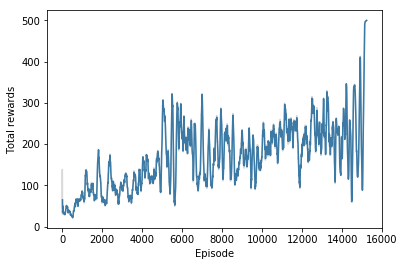

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

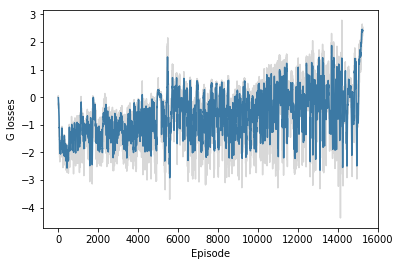

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

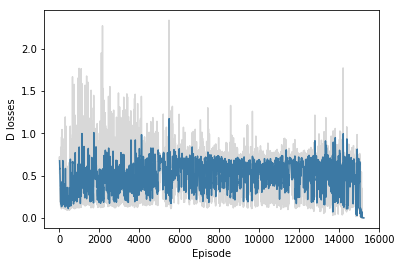

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

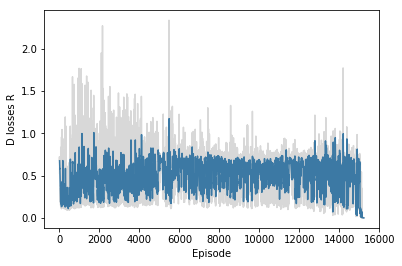

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

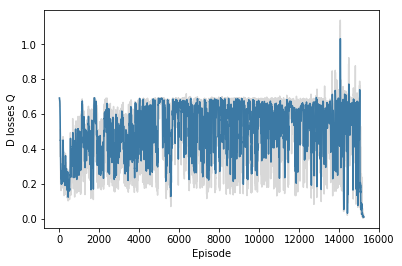

In [34]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
    # if total_reward == 500:
    #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.